# Scenario 1 - Chicago Airbnb
You and a group of friends are considering purchasing a property in Chicago that you can use as an investment. You have heard from other people that they have made a lot of money by renting out either a room or an entire unit (apartment or house). Your friends ask you to analyze data so that they can understand how much you would charge per night based on the type of dwelling you were to purchase.



In [38]:
# importing libraries
import seaborn as sns
import pandas as pd
import joblib
from sqlalchemy import create_engine


In [39]:
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'pdahal001' # this is the password established during installation
port = r'5432' # default port estabalished during install

In [40]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6397 entries, 0 to 6396
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6397 non-null   int64  
 1   name                            6397 non-null   object 
 2   host_id                         6397 non-null   int64  
 3   host_name                       6397 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   6397 non-null   object 
 6   latitude                        6397 non-null   float64
 7   longitude                       6397 non-null   float64
 8   room_type                       6397 non-null   object 
 9   price                           6397 non-null   int64  
 10  minimum_nights                  6397 non-null   int64  
 11  number_of_reviews               6397 non-null   int64  
 12  last_review                     52

The dataset contains 6,397 listings with key details about hosts, locations, pricing, and availability. However, the neighbourhood_group column is completely empty, making it unusable. Additionally, review-related data (last_review and reviews_per_month) have missing values, likely because some listings have never been reviewed. Despite these gaps, the dataset provides valuable information for analyzing pricing trends, host activity, and listing availability.

In [42]:
# loading the csv file
df= pd.read_csv('listings.csv')

In [43]:

# Randomly select 100 rows from the DataFrame
test_rows = df.sample(n=100, random_state=42)


In [44]:
# Save the sampled rows to a new CSV file
test_rows.to_csv('live_data.csv', index=False)

In [45]:
# Remove the sampled rows from the primary DataFrame
df = df.drop(test_rows.index)

In [46]:
# save the updated primary DataFrame to a new CSV file
df.to_csv('updated_data.csv', index=False)
print("Sampled data saved to 'live_data.csv' and removed from the primary DataFrame.")

Sampled data saved to 'live_data.csv' and removed from the primary DataFrame.


In [47]:
table_name = r'listing'
schema = r'raw' 

df.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

6297

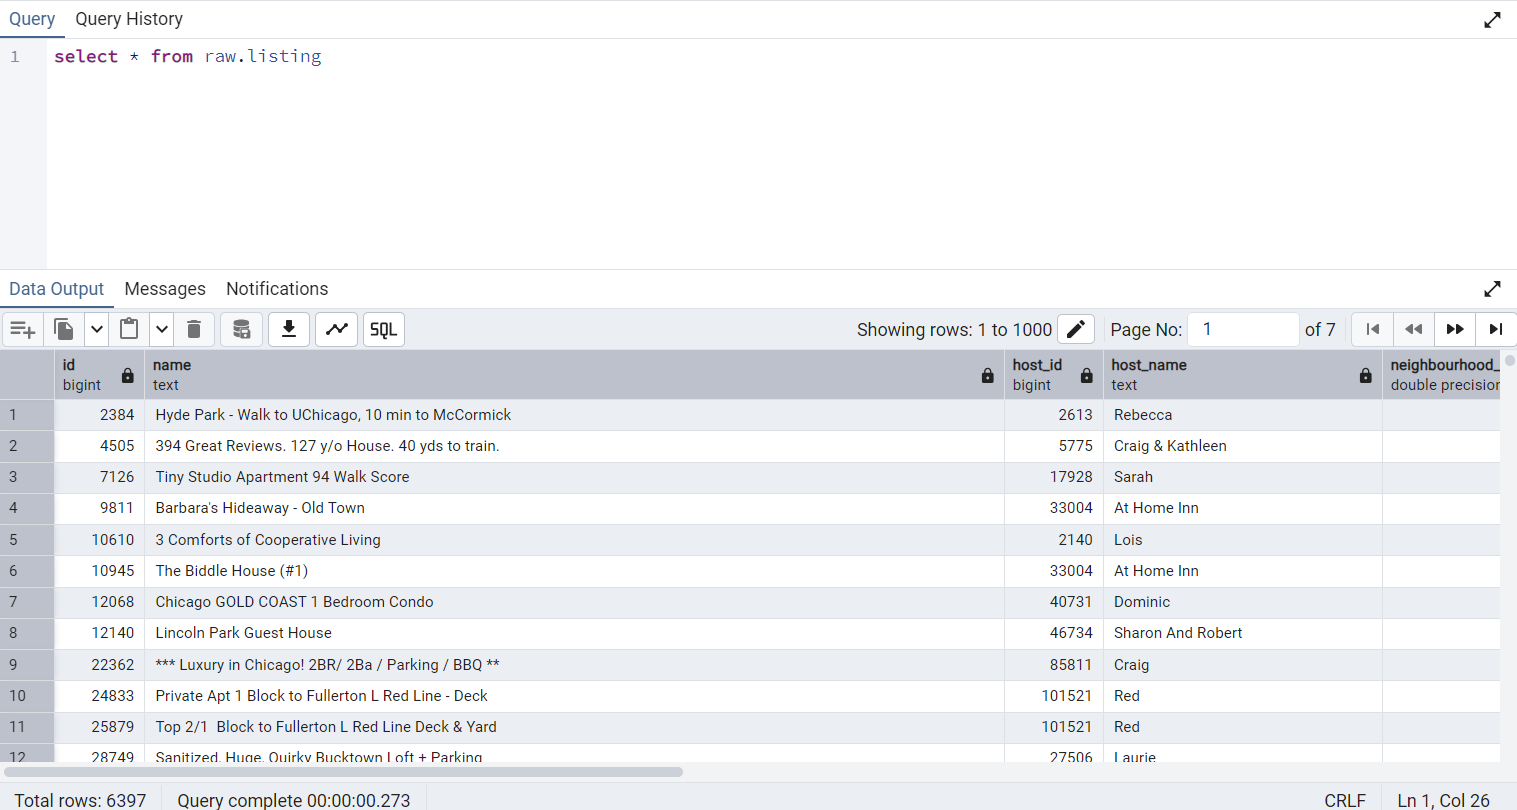

# Dataset Description and Data Definition

## Dataset Description
This dataset contains information on rental properties listed in Chicago, which can be used to analyze rental trends and pricing. It includes details about property locations, room types, pricing, host activity, and availability. The dataset is useful for estimating rental prices and understanding factors that influence pricing, such as property type, location, and demand.

The dataset consists of the following key attributes:
- **Listing Details**: Unique ID, name, and host information.
- **Location Information**: Neighborhood, latitude, and longitude.
- **Property Characteristics**: Room type and minimum nights required for booking.
- **Pricing and Reviews**: Nightly price, number of reviews, and reviews per month.
- **Host Activity**: Number of properties managed by the host and availability of listings throughout the year.

## Data Definition  
- **`id`**: A unique identifier assigned to each property listing. (Discrete)  
- **`name`**: The title or name given to the listing by the host. (Nominal)  
- **`host_id`**: A unique identifier assigned to each host. (Discrete)  
- **`host_name`**: The name of the host who owns or manages the listing. (Nominal)  
- **`neighbourhood_group`**: A higher-level grouping of neighborhoods (empty in this dataset).  
- **`neighbourhood`**: The specific neighborhood where the property is located. (Nominal)  
- **`latitude`**: The geographical latitude of the property location. (Continuous)  
- **`longitude`**: The geographical longitude of the property location. (Continuous)  
- **`room_type`**: The type of rental space available (e.g., Entire home/apt, Private room, Shared room). (Nominal)  
- **`price`**: The nightly rental price of the listing in USD. (Continuous)  
- **`minimum_nights`**: The minimum number of nights a guest must book for a stay. (Discrete)  
- **`number_of_reviews`**: The total number of reviews the listing has received. (Discrete)  
- **`last_review`**: The date when the last review was submitted. (Nominal)  
- **`reviews_per_month`**: The average number of reviews the listing receives per month. (Continuous)  
- **`calculated_host_listings_count`**: The total number of properties managed by the same host. (Discrete)  
- **`availability_365`**: The number of days in a year that the listing is available for booking. (Discrete)  




# Analytical Question

"What factors influence the nightly rental price of a property in Chicago, and how can we estimate the expected price based on the type of dwelling and location?"

The target variable is price because the main goal is to determine how much to charge per night for a rental property in Chicago. This requires predicting or analyzing the nightly price based on various factors.

In [48]:
# Display the first few rows of the dataset
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168


# Feature Selection for Price Analysis

## Relevant Features
The following features are retained as they provide insights into factors influencing **rental price**:

1. **`neighbourhood`** – Location impacts rental prices due to demand, proximity to amenities, and safety.  
2. **`latitude` & `longitude`** – Geospatial coordinates allow precise location-based analysis and clustering.  
3. **`room_type`** – Different room types (Entire home, Private room, Shared room) have different pricing trends.  
4. **`minimum_nights`** – Properties with high minimum night requirements might have lower per-night rates.  
5. **`availability_365`** – Availability influences demand and potential earnings.  
6. **`number_of_reviews`** – Listings with more reviews may indicate popularity and trust, affecting price.  
7. **`reviews_per_month`** – Frequent reviews can signal high demand, which may correlate with pricing.  
8. **`calculated_host_listings_count`** – Hosts managing multiple listings may have different pricing strategies.  

## Removed Features and Reasons
The following features are removed as they do not directly support price analysis:

1. **`id`** – A unique identifier that does not contribute to price prediction.  
2. **`name`** – The listing title is a textual feature that does not directly impact pricing.  
3. **`host_id` & `host_name`** – These are identifiers for hosts and do not influence price directly.  
4. **`neighbourhood_group`** – This column is empty in our dataset.  
5. **`last_review`** – A timestamp that does not directly correlate with price. 

In [49]:
# Drop irrelevant columns
columns_to_remove = ["id", "name", "host_id", "host_name", "neighbourhood_group", "last_review"]
df_cleaned = df.drop(columns=columns_to_remove, axis=1)

# Data Cleaning and Preparation for Machine Learning

Before applying machine learning models, we need to clean and prepare the data to ensure accuracy and reliability. The key steps include handling missing values, dealing with outliers, and converting categorical variables.

## 1. Handling Missing Values
Missing values can lead to incorrect analysis and must be addressed appropriately:
- **`reviews_per_month`**: Missing values likely indicate listings with no reviews. We replace them with `0`.
- **Other missing values**: If necessary, we can remove rows with missing essential data.

## 2. Handling Outliers
Outliers can skew results and impact model performance:
- **`price`**: Extreme prices (e.g., very high nightly rates) may be unrealistic and should be removed using a reasonable threshold.
- **`minimum_nights`**: Listings with excessively high `minimum_nights` (e.g., 365 days) are likely not representative of short-term rentals and should be filtered.

## 3. Converting Categorical Variables
Machine learning models require numerical data:
- **`room_type`**: Convert into numerical values using one-hot encoding.
- **`neighbourhood`**: Convert into numerical values using one-hot encoding or label encoding.


In [50]:
# 1.  Handling Missing Values
df_cleaned["reviews_per_month"] = df_cleaned["reviews_per_month"].fillna(0)  # Replace NaN with 0


In [51]:
# Drop rows with missing values in critical columns
df_cleaned.dropna(inplace=True)

In [52]:
# 2. Handling Outliers
# Remove listings with price <= 0 or very high values (e.g., > $1000)
df_cleaned = df_cleaned[(df_cleaned["price"] > 0) & (df_cleaned["price"] <= 1000)]

In [53]:
# Remove listings with unrealistic minimum nights (e.g., > 365)
df_cleaned = df_cleaned[df_cleaned["minimum_nights"] <= 365]


In [54]:
# Search for this specific value
df[df['name'] == 'Inspiration Station Studio Apartment']

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
4998,40371125,Inspiration Station Studio Apartment,56920056,Patrick,NaN,Uptown,41.96439,-87.66731,Entire home/apt,98,30,3,2020-03-15,0.34,1,180


In [55]:
# 3. Converting Categorical Variables
# One-hot encoding for 'room_type' and 'neighbourhood'
df_cleaned = pd.get_dummies(df_cleaned, columns=["room_type", "neighbourhood"], drop_first=True)

In [56]:
# Check for missing values after handling them
print("Missing values after handling:\n", df_cleaned.isnull().sum())

Missing values after handling:
 latitude                      0
longitude                     0
price                         0
minimum_nights                0
number_of_reviews             0
                             ..
neighbourhood_West Lawn       0
neighbourhood_West Pullman    0
neighbourhood_West Ridge      0
neighbourhood_West Town       0
neighbourhood_Woodlawn        0
Length: 87, dtype: int64


In [57]:
import pandas as pd

# Define the data cleansing schema
cleaning_schema = pd.DataFrame({
    "Field Name": [
        # Numeric Fields
        "price", "number_of_reviews", "reviews_per_month", "minimum_nights",
        "availability_365", "calculated_host_listings_count",
        
        # Categorical Fields
        "room_type", "neighbourhood_group", "neighbourhood", "host_name",
        
        # Date Fields
        "last_review",
        
        # Text Fields
        "name", "description",
        
        # Boolean Fields
        "instant_bookable"
    ],
    
    "Data Type": [
        "Numeric", "Numeric", "Numeric", "Numeric", "Numeric", "Numeric",
        "Categorical", "Categorical", "Categorical", "Categorical",
        "Date",
        "Text", "Text",
        "Boolean"
    ],
    
    "Cleaning Operation": [
        "Outlier Removal + Log Transform", "Missing Value Imputation + Outlier Capping",
        "Missing Value Imputation", "Outlier Capping", "Range Validation", "Missing Value Imputation",
        "One-Hot Encoding", "One-Hot Encoding", "Frequency Encoding", "Count Encoding",
        "Convert to DateTime + Extract Features",
        "Text Cleaning + NLP Features", "Text Cleaning + NLP Features",
        "Binary Encoding"
    ],
    
    "Cleaning Details": [
        "Remove IQR outliers, then log transform", "Fill NaN with median, cap at 99th percentile",
        "Fill NaN with 0", "Cap values above 30 to 30", "Filter values between 0-365",
        "Fill NaN with mode",
        "Convert to dummy variables", "Convert to dummy variables",
        "Replace with frequency of each category", "Replace with count of occurrences",
        "Convert to datetime, extract month, year, day_of_week",
        "Remove special chars, lowercase, create length feature",
        "Remove special chars, lowercase, create length feature",
        "Convert to 0/1"
    ],
    
    "Missing Value Strategy": [
        "Remove if >30% missing", "Median imputation", "Zero imputation", "Median imputation",
        "Zero imputation", "Mode imputation",
        "Create missing category", "Create missing category", "Create missing category",
        "Create missing category", "Fill with earliest date",
        "Fill with 'Unknown'", "Fill with 'No description'", "Fill with most frequent"
    ],
    
    "Validation Rules": [
        "price > 0", "number_of_reviews >= 0", "reviews_per_month >= 0", "minimum_nights > 0",
        "0 <= availability_365 <= 365", "calculated_host_listings_count >= 0",
        "Must be in allowed categories", "Must be in allowed categories", "Must be valid neighbourhood",
        "No validation required", "Must be valid date",
        "No validation required", "No validation required", "Must be True/False"
    ],
    
    "Feature Priority": [
        "High", "Medium", "Medium", "High", "High", "Low",
        "High", "Medium", "Medium", "Low", "Medium",
        "Low", "Low", "Medium"
    ]
})

# Save schema to CSV for reference
cleaning_schema.to_csv("data_cleansing_schema.csv", index=False)




In [58]:
table_name = r'clean_process'
schema = r'raw' 
cleaning_schema.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

14

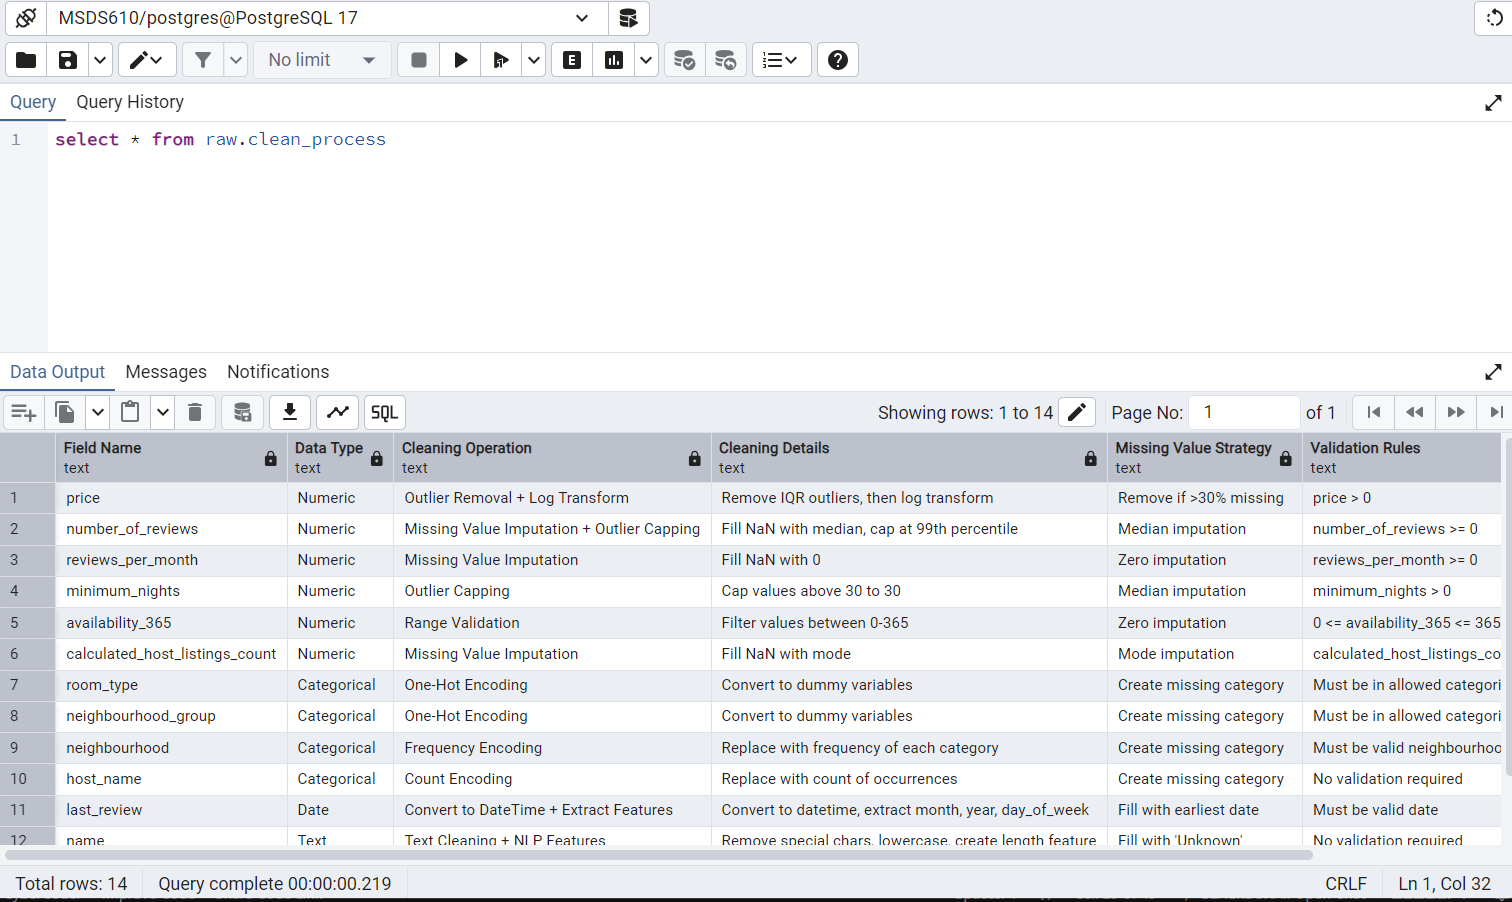

# Feature Engineering

Availability ratio: It is done by calculating the percentage of the year the property is available (availability_365 / 365). This helps capture the owner's intent to rent long-term or short-term.

Price Seasonability score: The Price Seasonality Score is calculated by combining three key factors: availability (50% weight), minimum nights (30% weight), and review frequency (20% weight) to capture how property prices might vary based on seasonal demand patterns. This score is useful because it helps identify peak vs. off-peak pricing periods and allows property owners to adjust their rates based on seasonal demand in the Chicago rental market.

Review Intensity Score: This is found out by combining the number_of_reviews and reviews_per_month into a single metric that captures overall review intensity. It is added because a property that has a high number of reviews and high review frequency (reviews per month) may indicate higher demand, influencing the price.


In [59]:
# Feature 1: Length of availability as a percentage of the year
df_cleaned['availability_ratio'] = df_cleaned['availability_365'] / 365

In [60]:
# Feature 2: Price Seasonality Score
def calculate_seasonality_score(row):
    # Base score from availability
    availability_score = row['availability_365'] / 365.0
    
    # Adjust score based on minimum nights (shorter stays might indicate peak season pricing)
    min_nights_factor = 1 - (row['minimum_nights'] / 30)  # Normalize to month
    
    # Adjust score based on review frequency (more reviews might indicate peak seasons)
    review_factor = row['reviews_per_month'] / 5 if row['reviews_per_month'] else 0
    
    # Combine factors with weights
    seasonality_score = (
        0.5 * availability_score +  # Weight for availability
        0.3 * min_nights_factor +   # Weight for minimum nights
        0.2 * review_factor         # Weight for review frequency
    )
    
    return seasonality_score

df_cleaned['price_seasonality'] = df_cleaned.apply(calculate_seasonality_score, axis=1)


In [61]:
# Feature 3: Review Intensity Score
df_cleaned['review_intensity'] = df_cleaned['number_of_reviews'] * df_cleaned['reviews_per_month']



# Normalized features:
Applied MinMax scaling to the following continuous variables:

minimum_nights

number_of_reviews

reviews_per_month

calculated_host_listings_count

This step ensures that these features have a consistent scale, improving model performance.

In [62]:
# Normalizing features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_normalize = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']
df_cleaned[columns_to_normalize] = scaler.fit_transform(df_cleaned[columns_to_normalize])
joblib.dump(scaler, 'feature_scaler.pkl')


['feature_scaler.pkl']

# Selecting the Right Algorithm

Choosing the right model depends on the nature of the data. Since we are working with a vehicle dataset and predicting a continuous numeric value (likely price), we are dealing with a regression problem.

The key considerations for selecting the algorithm are:

Dataset Size – If the dataset is large, we need an algorithm that scales well.

Feature Relationships – We have engineered several new features, and a linear relationship might not fully capture them.

Robustness & Interpretability – The model should generalize well and avoid overfitting.

Chosen Algorithm: Random Forest Regressor 

Handles Non-Linear Relationships – Unlike Linear Regression, Random Forest can model complex interactions.

Resistant to Outliers – Since it uses multiple decision trees, it isn’t as sensitive to extreme values.

Feature Importance – We can interpret which features are most influential in price prediction.

Handles Missing Data Well – Can handle datasets where some values may be missing.


 # 3-Way Data Split

 A 3-way split ensures our model is well-evaluated and optimized:

Training Set (70%) – Used to train the model.

Validation Set (15%) – Used to fine-tune hyperparameters.

Test Set (15%) – Used to evaluate final model performance


# Model Optimization Steps
We will go through an iterative process to find the best parameters for our model.

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [64]:
# Defining target and features
X = df_cleaned.drop(columns=['price'])  # Drop target variable
y = df_cleaned['price']  # Use raw price values

In [65]:
# Split the data into train, validation, and test sets (60/20/20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [66]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

In [67]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [68]:
# Get the best model
best_model = grid_search.best_estimator_

In [69]:
# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Validation MSE:", val_mse)
print("Validation R2:", val_r2)

# Final evaluation on the test set
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test MSE:", test_mse)
print("Test R2:", test_r2)

Validation MSE: 8983.22062538486
Validation R2: 0.3214603392725871
Test MSE: 9742.309043845305
Test R2: 0.2715504963635227


# Interpreting Results

## MSE (Mean Squared Error)
**Validation MSE:** 8983.22  
**Test MSE:** 9742.31  

These high MSE values indicate:  

- On average, your model's predictions deviate by about **$94.78** (√8983.22) from actual prices in the validation set.  
- For the test set, predictions deviate by about **$98.70** (√9742.31).  
- These are relatively large errors considering the price range of Airbnb listings.  

## R² Score (Coefficient of Determination)
**Validation R²:** 0.3215 (**32.15%**)  
**Test R²:** 0.2716 (**27.16%**)  

These low R² values indicate:  

- The model explains only about **32.15%** of the price variance in the validation data.  
- Performance drops to explaining only **27.16%** of variance in the test data.  
- A large portion of price variation (**about 68-73%**) remains unexplained by the model.  


In [70]:
# Saving the best model using joblib
joblib.dump(best_model, "random_forest.pkl")

['random_forest.pkl']

In [71]:
# Saving the list of feature names from X_train
model_features = list(X_train.columns)

# Save feature names to a file for later use
joblib.dump(model_features, "model_features.pkl")

['model_features.pkl']

In [72]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168
